In [1]:
include("../src/PowerPhaseRetrieval.jl")
import PowerModels as PM
import .PowerPhaseRetrieval as PPR
using JuMP,Ipopt
using LinearAlgebra,Random,Statistics
using Plots,LaTeXStrings

[info | PowerModels]: Suppressing information and warning messages for the rest of this session.  Use the Memento package for more fine-grained control of logging.


┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.compute_basic_ac_pf! :: Tuple{Dict{String, Any}}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Main.PowerPhaseRetrieval.calc_closest_rank_r :: Tuple{Matrix, Integer}` in module `Main.PowerPhaseRetrieval`
└ @ Base.Docs docs/Docs.jl:240


In [2]:
function is_gershdisc_invertible(A::AbstractMatrix)
    n = size(A)[1]
    lhs,rhs = [],[]
    for i=1:n
        push!(lhs,abs(A[i,i]))
        push!(rhs,sum([abs(A[k,i]) for k=1:n if k != i]))
    end
    return all(lhs .> rhs)
end

is_gershdisc_invertible (generic function with 1 method)

In [3]:
function is_diagonally_dominant(A::AbstractMatrix)
    n = size(A)[1]
    is = true
    for i=1:n
        if sum([abs(A[k,i]) for k=1:n if k != i]) > abs(A[i,i])
            is = false
        end    
    end
    return is
end

row_offdiag_sum(A) = [sum([abs(A[k,i]) for k=1:size(A)[1] if k != i]) for i=1:size(A)[1]]
col_offdiag_sum(A) = [sum([abs(A[i,k]) for k=1:size(A)[1] if k != i]) for i=1:size(A)[1]]

col_offdiag_sum (generic function with 1 method)

In [13]:
"""
Struct for the Δθ observability condition in Theorem 1.
"""
struct PhaseObservability
    lhs::Vector{Float64}
    rhs_row::Vector{Float64}
    rhs_col::Vector{Float64}
    observable::Vector{Bool}
    strong_observable::Vector{Bool}
end

function calc_phase_observability(net::Dict;sel_bus_types =[1])
    sel_bus_idx = PPR.calc_bus_idx_of_type(net,sel_bus_types)
    n_bus = length(sel_bus_idx)
    J = PPR.calc_jacobian_matrix(net)
    v = abs.(PM.calc_basic_bus_voltage(net))[sel_bus_idx]
    q = imag.(PM.calc_basic_bus_injection(net))[sel_bus_idx]
    Sqv = J.qv[sel_bus_idx,sel_bus_idx]
    @assert length(v) == length(q) == size(Sqv)[1] == size(Sqv)[2]
    rhs_col,rhs_row = [],[]
    lhs,observable,strong_observable = [],[],[]
    for i = 1:n_bus
        push!(lhs,
            #abs(v[i]*Sqv[i,i]) + 2*abs.(q[i]) + abs(Sqv[i,i])
            #abs(Sqv[i,i]) + abs(v[i]*Sqv[i,i] - 2*q[i])
            abs(Sqv[i,i]*v[i] - 2*q[i])
        )
        push!(rhs_row,
            #sum([(1+v[k])*abs(Sqv[i,k]) for k =1:n_bus if k!=i])
            (1 + v[i])*sum([abs(Sqv[k,i]) for k=1:n_bus if k != i])
        )
        push!(rhs_col,
            sum([(1+v[k])*abs(Sqv[i,k]) for k =1:n_bus if k!=i])
        )
        push!(observable,
            #abs(q[i]) >= 0.5*v[i]*(sum([abs(Sqv[k,i]) for k=1:n_bus if k!= i])- abs(Sqv[i,i]))
            (lhs[i] >= rhs_row[i]) || (lhs[i] >= rhs_col[i])
            #abs(q[i]) >=  (1/2)*(1+v[i])*(sum([abs(Sqv[k,i]) for k=1:n_bus if k!=i])- abs(Sqv[i,i]))
        )
        push!(strong_observable,
            #abs(q[i]) >= 0.5*v[i]*(sum([abs(Sqv[k,i]) for k=1:n_bus if k!= i])- abs(Sqv[i,i]))    
            (abs(q[i]) >= 0.5*(1+v[i])*(sum([abs(Sqv[k,i]) for k=1:n_bus if k!=i])- abs(Sqv[i,i]))) || ((1+v[i])*abs(Sqv[i,i]) + 2*abs(q[i])>=sum([(1+v[k])*abs(Sqv[i,k]) for k =1:n_bus if k!=i]))
        )
    end
    return PhaseObservability(
        lhs,rhs_row,rhs_col,observable,strong_observable
    )
end

function calc_phase_observability!(net::Dict) 
    PM.compute_ac_pf!(net) 
    return calc_phase_observability(net)
end

calc_phase_observability! (generic function with 1 method)

In [20]:
function dpdth_observability(net::Dict;sel_bus_types =[1])
    sel_bus_idx = PPR.calc_bus_idx_of_type(net,sel_bus_types)
    n_bus = length(sel_bus_idx)
    J = PPR.calc_jacobian_matrix(net)
    v = abs.(PM.calc_basic_bus_voltage(net))[sel_bus_idx]
    q = imag.(PM.calc_basic_bus_injection(net))[sel_bus_idx]
    Sqv = J.qv[sel_bus_idx,sel_bus_idx]
    @assert length(v) == length(q) == size(Sqv)[1] == size(Sqv)[2]
    rhs_col,rhs_row = [],[]
    lhs = []
    observable,strong_observable = [],[]
    for i=1:n_bus
        push!(lhs,
            abs(v[i]*Sqv[i,i] - 2*q[i])
        )
        push!(rhs_row,
            sum([v[i]*abs(Sqv[k,i]) for k =1:n_bus if k!= i])  
        )
        push!(rhs_col,
            sum([abs(Sqv[i,k]*v[k]) for k=1:n_bus if k!=i])
        )
        push!(observable,
            (lhs[i] >= rhs_row[i]) || (lhs[i] >= rhs_col[i])
        )
        push!(strong_observable,
            abs(q[i]) >= 0.5*v[i]*(sum([abs(Sqv[k,i]) for k=1:n_bus if k!= i])- abs(Sqv[i,i])) || abs(q[i]) >= 0.5*(sum([abs(Sqv[k,i])*v[k] for k=1:n_bus if k!= i])- abs(Sqv[i,i]))   
        )
    end
    return PhaseObservability(
        lhs,rhs_row,rhs_col,observable,strong_observable
    )
end

dpdth_observability (generic function with 1 method)

In [23]:
pct_observable["case118.m"]

1.0

In [25]:
pct_observable["case_ieee30.m"]

0.7916666666666666

In [22]:
#Calculate the percentage of PQ buses that are guaranteed to recover the voltage phase angles.
network_path = "/home/sam/Research/PowerPhaseRetrieval/data/" #"/home/sam/github/PowerSensitivities.jl/data/radial_test/" #
pct_observable = Dict()
pct_strong_observable = Dict()
max_margin = Dict() #maximum radii over the left hand side of the complex plane
for name in ["case_RTS_GMLC.m","case24_ieee_rts.m","case_ieee30.m","case118.m"]
    net_path = network_path*name
    net = PM.make_basic_network(PM.parse_file(net_path))
    PM.compute_ac_pf!(net)
    ph_obs = dpdth_observability(net,sel_bus_types=[1])
    n_bus = length(ph_obs.lhs)
    pct_observable[name] = sum(ph_obs.observable)/length(ph_obs.observable)
    pct_strong_observable[name] = sum(ph_obs.strong_observable)/length(ph_obs.observable)
    # max_margin[name] = maximum(
    #     abs.(
    #         [ph_obs.lhs[i] - minimum([ph_obs.rhs_row[i],ph_obs.rhs_col[i]]) for i =1:n_bus if ph_obs.strong_observable[i] == 0]
    #     )
    # )
end
#println("weak: ",pct_observable)
#println("strong: ",pct_strong_observable)
#println(max_margin)

In [31]:
net = PM.make_basic_network(PM.parse_file("/home/sam/Research/PowerPhaseRetrieval/data/case_ieee30.m"))

Dict{String, Any} with 14 entries:
  "basic_network"  => true
  "bus"            => Dict{String, Any}("24"=>Dict{String, Any}("zone"=>1, "bus…
  "source_type"    => "matpower"
  "name"           => "case_ieee30"
  "dcline"         => Dict{String, Any}()
  "source_version" => "2"
  "gen"            => Dict{String, Any}("4"=>Dict{String, Any}("pmin"=>0.0, "qc…
  "branch"         => Dict{String, Any}("24"=>Dict{String, Any}("br_r"=>0.034, …
  "storage"        => Dict{String, Any}()
  "switch"         => Dict{String, Any}()
  "baseMVA"        => 100
  "per_unit"       => true
  "shunt"          => Dict{String, Any}("1"=>Dict{String, Any}("source_id"=>Any…
  "load"           => Dict{String, Any}("4"=>Dict{String, Any}("source_id"=>Any…

In [27]:
is_100 = 0
for (name,pct) in pct_observable
    if pct ≈ 1 && pct != NaN && pct != nothing
        is_100 += 1
    end
end
pct_cases_obs = is_100/length(pct_observable)
println("pct_cases normal obs: ",pct_cases_obs)

is_100 = 0
for (name,pct) in pct_strong_observable
    if pct ≈ 1 && pct != NaN && pct != nothing
        is_100 += 1
    end
end
pct_cases_strong_obs = is_100/length(pct_strong_observable)
println("pct_cases strong obs: ",pct_cases_strong_obs)


pct_cases normal obs: 0.75
pct_cases strong obs: 0.75


## $dp/d\theta$ only-condition

In [63]:
net = PM.make_basic_network(PM.parse_file("/home/sam/Research/PowerPhaseRetrieval/data/case_ieee30.m"))
PM.compute_ac_pf!(net)
Y = PM.calc_admittance_matrix(net)
J_model = PPR.calc_jacobian_matrix(net,[1])
J = Matrix(J_model.matrix)
sel_bus_idx = PPR.calc_bus_idx_of_type(net,[1])
n_bus = length(sel_bus_idx)
v = abs.(PM.calc_basic_bus_voltage(net))[sel_bus_idx]
q = imag.(PM.calc_basic_bus_injection(net))[sel_bus_idx]
Spth,Sqv = Matrix(J_model.pth),Matrix(J_model.qv)
Sqth,Spv = Matrix(J_model.qth),Matrix(J_model.pv)
@assert length(v) == length(q) == size(Sqv)[1] == size(Sqv)[2]
println(is_gershdisc_invertible(J))
println(is_gershdisc_invertible(Spth))
println(is_gershdisc_invertible(Sqv))
println(is_gershdisc_invertible(Sqv - Sqth*inv(Spth)*Spv))

weak_observable = [] 
strong_observable = []
Strong_LHS,Weak_LHS = [],[]
Row_RHS,Col_RHS = [],[]
for i = 1:n_bus
    row_rhs = sum(
        v[i]*[abs(Sqv[k,i]) for k=1:n_bus if k!== i]
    )
    push!(Row_RHS,row_rhs)

    col_rhs = sum(
        [abs(v[k]*Sqv[i,k]) for k=1:n_bus if k!== i]
    )
    push!(Col_RHS,col_rhs)

    weak_lhs = abs(v[i]*Sqv[i,i]-2*q[i]) 
    push!(Weak_LHS,weak_lhs)
    
    strong_lhs = abs(v[i]*Sqv[i,i]) + 2*abs(q[i])
    push!(Strong_LHS,strong_lhs)
    
    push!(weak_observable,
        (weak_lhs>=row_rhs) || (weak_lhs >= col_rhs)
    )
    push!(strong_observable,
        (strong_lhs >= row_rhs) || (strong_lhs>= col_rhs)
    )
end

margin = []
for i=1:n_bus
    if strong_observable[i] ==0
        push!(margin,
        abs(Strong_LHS[i] - minimum([Row_RHS[i],Col_RHS[i]]))
        )
    else
        push!(margin,0)
    end
end
max_margin = maximum(margin)

println("pct weak_observable: ",sum(weak_observable)/n_bus)
println("pct strong observable: ",sum(strong_observable)/n_bus)
println("max margin: ",max_margin)

false
false
false
false
pct weak_observable: 0.7916666666666666
pct strong observable: 0.7916666666666666
max margin: 1.4210854715202004e-14


## full jacobian condition

In [64]:
net = PM.make_basic_network(PM.parse_file("/home/sam/Research/PowerPhaseRetrieval/data/case_ieee30.m"))
PM.compute_ac_pf!(net)
Y = PM.calc_admittance_matrix(net)
J_model = PPR.calc_jacobian_matrix(net,[1])
J = Matrix(J_model.matrix)
sel_bus_idx = PPR.calc_bus_idx_of_type(net,[1])
n_bus = length(sel_bus_idx)
v = abs.(PM.calc_basic_bus_voltage(net))[sel_bus_idx]
q = imag.(PM.calc_basic_bus_injection(net))[sel_bus_idx]
Spth,Sqv = Matrix(J_model.pth),Matrix(J_model.qv)
Sqth,Spv = Matrix(J_model.qth),Matrix(J_model.pv)
@assert length(v) == length(q) == size(Sqv)[1] == size(Sqv)[2]
println(is_gershdisc_invertible(J))
println(is_gershdisc_invertible(Spth))
println(is_gershdisc_invertible(Sqv))
println(is_gershdisc_invertible(Sqv - Sqth*inv(Spth)*Spv))

weak_observable = [] 
strong_observable = []
Strong_LHS,Weak_LHS = [],[]
Row_RHS,Col_RHS = [],[]
for i = 1:n_bus
    row_rhs = (1+v[i])*sum(
        [abs(Sqv[k,i]) for k=1:n_bus if k!== i]
    )
    push!(Row_RHS,row_rhs)

    col_rhs = sum(
        [(1+v[k])*abs(Sqv[i,k]) for k=1:n_bus if k!== i]
    )
    push!(Col_RHS,col_rhs)

    weak_lhs = abs(Sqv[i,i]) + abs(v[i]*Sqv[i,i]-2*q[i]) 
    push!(Weak_LHS,weak_lhs)

    strong_lhs = (1+v[i])*abs(Sqv[i,i]) + 2*abs(q[i])
    push!(Strong_LHS,strong_lhs)
    
    push!(weak_observable,
        (weak_lhs>=row_rhs) || (weak_lhs >= col_rhs)
    )
    push!(strong_observable,
        (strong_lhs >= row_rhs) || (strong_lhs>= col_rhs)
    )
end

margin = []
for i=1:n_bus
    if strong_observable[i] ==0
        push!(margin,
        abs(Strong_LHS[i] - minimum([Row_RHS[i],Col_RHS[i]]))
        )
    else
        push!(margin,0)
    end
end
max_margin = maximum(margin)


println("pct weak_observable: ",sum(weak_observable)/n_bus)
println("pct strong observable: ",sum(strong_observable)/n_bus)
println("max margin: ",max_margin)

false
false
false
false
pct weak_observable: 0.625
pct strong observable: 0.625
max margin: 0.0781539706643315


In [74]:
ph_obs = calc_phase_observability(net,sel_bus_types=[1])

PhaseObservability([60.098996918690005, 112.97934732989373, 168.20916482047875, 37.044468284941566, 40.31729894735409, 88.45295494993772, 53.116166074705504, 11.546701961058396, 33.85616467889574, 19.09941920013044  …  94.69491731331888, 91.34987305645024, 14.503800231065792, 18.976640289294558, 16.140931177731048, 3.6323189838272367, 19.585243692873398, 45.806234406116275, 7.2454467857794365, 5.961510304302292], [47.5718230953043, 102.59598589399334, 113.19472295916442, 22.521339217516008, 29.648693195062275, 88.08695300560633, 37.106973193785265, 11.663096182970502, 34.01282201949488, 19.18694831220172  …  95.0968269743001, 91.34810518198867, 14.57276619724457, 19.23464493115846, 16.13908356602752, 3.7145888177226345, 19.3225573764916, 36.78886394704449, 7.295146809112217, 6.159311042835445], [48.810017639522464, 102.01225535340396, 112.87466950228455, 21.979073629544157, 29.90090928673289, 88.81983404815664, 37.92995581993658, 11.541040644459613, 33.85376603526571, 19.10365675853476

In [75]:
sum(ph_obs.observable)/length(ph_obs.observable)

0.625

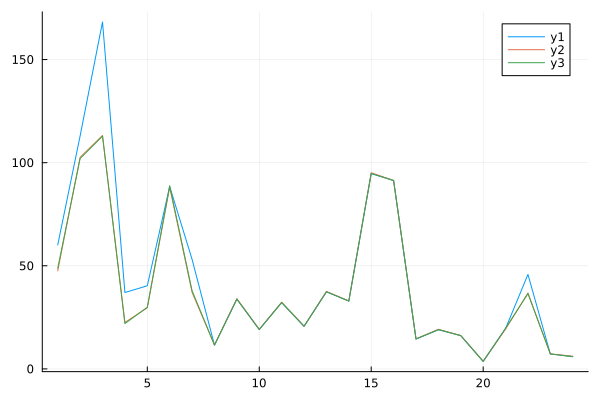

In [76]:
plot(ph_obs.lhs)
plot!(ph_obs.rhs_row)
plot!(ph_obs.rhs_col)

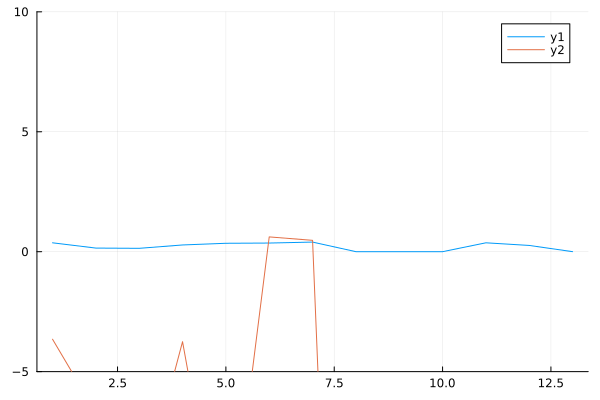

In [43]:
plot(abs.(q),ylims=(-5,10))
plot!([(1/2)*(1+v[i])*(sum([abs(Sqv[k,i]) for k=1:n_bus if k!=i])- abs(Sqv[i,i])) for i=1:n_bus])

In [26]:
inv(J) 

80×80 Matrix{Float64}:
 0.053616    0.00718338  0.00115399  0.00181629   …  0.0           0.0
 0.00719703  0.0643519   0.00150138  0.00234962      0.0           0.0
 0.00114572  0.00150711  0.0474643   0.0114974       0.0           0.0
 0.00181812  0.00240157  0.0115648   0.0616906       0.0           0.0
 0.00329097  0.00433021  0.00381045  0.00596325      0.0           0.0
 0.0129763   0.0169914   0.0026462   0.00411152   …  0.0           0.0
 0.00228787  0.00300042  0.0147486   0.0230055       0.0           0.0
 0.00247828  0.00321032  0.00284479  0.00436512      0.0           0.0
 0.00308111  0.00398385  0.0035289   0.00540195      0.0           0.0
 0.0         0.0         0.0         0.0             0.0           0.0
 0.0         0.0         0.0         0.0          …  0.0           0.0
 0.0         0.0         0.0         0.0             0.0           0.0
 0.0185626   0.00245524  0.00037372  0.000574957     0.0           0.0
 ⋮                                                ⋱   

In [47]:
sum(ph_obs.observable)/length(ph_obs.observable)

0.8461538461538461

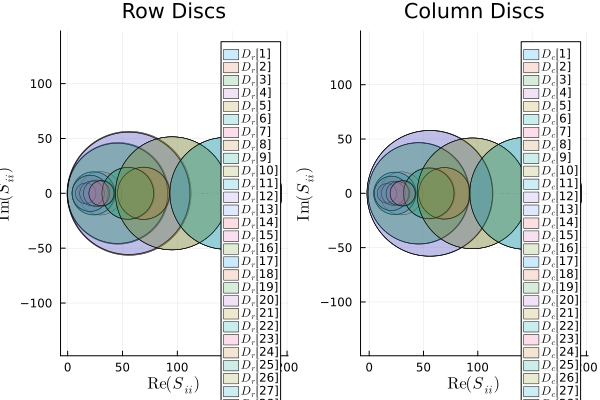

In [78]:
PPR.plot_gershdisc(Sqv)